# (experimental) notebook to stack multiple box-beam 3DXRD layer scans together  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

dset_path = ''

phase_str = 'Fe'

z_translation_motor = "samtz"

dset_prefix = "ff"

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/default/FeAu_0p5_tR/FeAu_0p5_tR_ff1/FeAu_0p5_tR_ff1_dataset.h5"
phase_str = "Fe"
z_translation_motor = "samtz"
dset_prefix = "ff"


In [4]:
import os
from collections import OrderedDict

import h5py
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset
from ImageD11.nbGui import nb_utils as utils
from ImageD11.sym_u import find_uniq_u, getgroup, cubic
from xfab.symmetry import Umis, ROTATIONS

%matplotlib widget

# Load data
## Single example dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/default"
sample = "FeAu_0p5_tR"
dset = "ff1"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229}

In [7]:
ucell = ds.phases.unitcells[phase_str]
print(ucell.lattice_parameters, ucell.spacegroup)

[ 2.8694  2.8694  2.8694 90.     90.     90.    ] 229


## All datasets

In [8]:
# you can optionally skip samples
# skips_dict = {
#     "FeAu_0p5_tR": ["ff6",]
# }
# otherwise by default skip nothing:
skips_dict = {
    ds.sample: []
}

sample_list = [ds.sample, ]

samples_dict = utils.find_datasets_to_process(ds.dataroot, skips_dict, dset_prefix, sample_list)

print(samples_dict)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}

{'FeAu_0p5_tR': ['ff1', 'ff2', 'ff3', 'ff4', 'ff5', 'ff6']}


In [9]:
# just take first sample for now

sample = sample_list[0]
datasets = samples_dict[sample]
ds_dict = OrderedDict()

# try to sort datasets alphabetically

datasets_sorted = sorted(datasets)

for dataset in datasets_sorted:
    dset_path = os.path.join(ds.analysisroot, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
    ds = ImageD11.sinograms.dataset.load(dset_path)
    print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
    ds_dict[dataset] = ds

I have a DataSet ff1 in sample FeAu_0p5_tR
I have a DataSet ff2 in sample FeAu_0p5_tR
I have a DataSet ff3 in sample FeAu_0p5_tR
I have a DataSet ff4 in sample FeAu_0p5_tR
I have a DataSet ff5 in sample FeAu_0p5_tR


I have a DataSet ff6 in sample FeAu_0p5_tR


In [10]:
# populate z translations

for ds in ds_dict.values():
    with h5py.File(ds.masterfile, 'r' ) as hin:
        this_z_trans_value = hin["1.1/instrument/positioners"][z_translation_motor][()]
    ds.zpos = this_z_trans_value  # this is in microns for samtz

In [11]:
# load grains for each dataset and tie them to the dataset objects
for ds in ds_dict.values():
    ds.grains = ds.get_grains_from_disk(phase_str)

In [12]:
# get positions within the sample (set middle slice as zero position)

middle_ds = list(ds_dict.values())[len(ds_dict.values())//2]
middle_pos = middle_ds.zpos

for ds in ds_dict.values():
    # adjust so that the first letterbox (lowest z so highest on the sample) has the highest value of zpos
    ds.zpos_sample = middle_pos - ds.zpos
    print(ds.zpos, ds.zpos_sample)

-0.33709999999999996 0.44999999999999996
-0.18710000000000004 0.30000000000000004
-0.03710000000000013 0.15000000000000013
0.1129 0.0
0.26290000000000013 -0.15000000000000013
0.41290000000000004 -0.30000000000000004


In [13]:
for inc, ds in enumerate(ds_dict.values()):
    for gid, grain in enumerate(ds.grains):
        grain.pos_sample = grain.translation + np.array([0., 0., ds.zpos_sample * 1000])
        grain.dataset = ds.dsname
        grain.z_slice = inc
        grain.gid = gid
        grain.ref_unitcell = ucell
        grain.mean_int = float(grain.intensity_info.split('mean = ')[1].split(' ,')[0])
    
    utils.get_rgbs_for_grains(ds.grains)

In [14]:
all_grains = []
for ds in ds_dict.values():
    all_grains.extend(ds.grains)

In [15]:
print(all_grains[0].pos_sample, all_grains[0].translation)

[ 83.3427 -96.4462 421.1261] [ 83.3427 -96.4462 -28.8739]


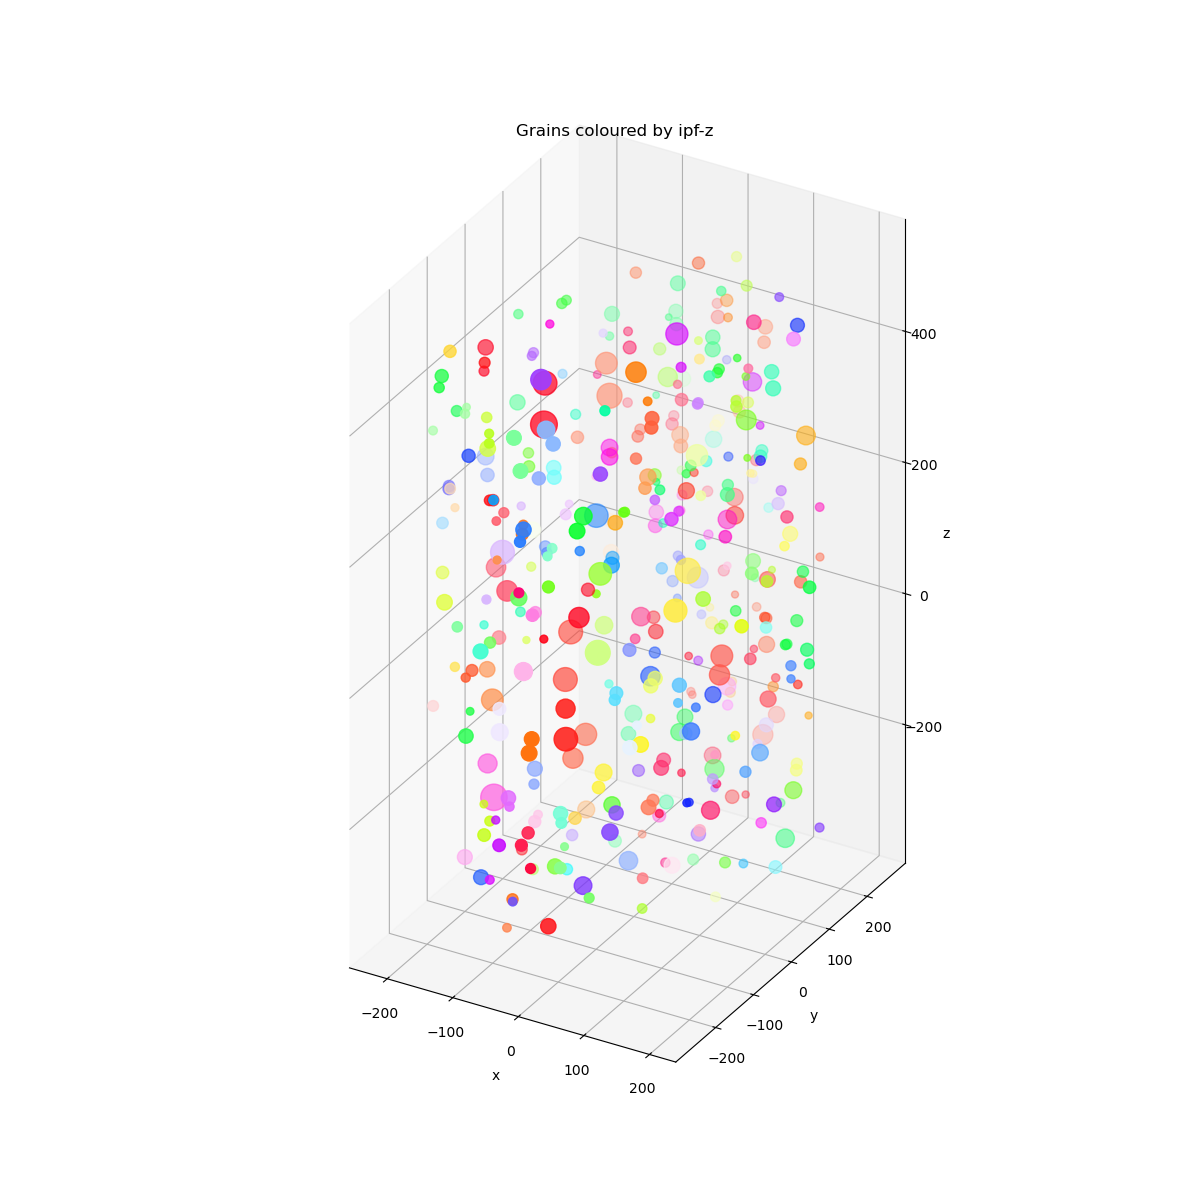

In [16]:
centre_plot = False
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d', proj_type='ortho')
colors = cm.rainbow(np.linspace(0, 1, len(list(ds_dict.values()))))
for ds in ds_dict.values():
    xx = [grain.pos_sample[0] for grain in ds.grains]
    yy = [grain.pos_sample[1] for grain in ds.grains]
    zz = [grain.pos_sample[2] for grain in ds.grains]
    scatterplot = ax.scatter(xx, yy, zz, c=[grain.rgb_z for grain in ds.grains], s=[0.1*np.power(g.mean_int, 2/3) for g in ds.grains], label=ds.grains[0].z_slice)
ax.set(title="Grains coloured by ipf-z", xlabel='x', ylabel='y', zlabel='z', aspect='equal')
plt.show()

/tmp/ipykernel_3217105/451643372.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatterplot = ax.scatter(xx, yy, zz, c=colors[ds.grains[0].z_slice], label=ds.grains[0].z_slice)


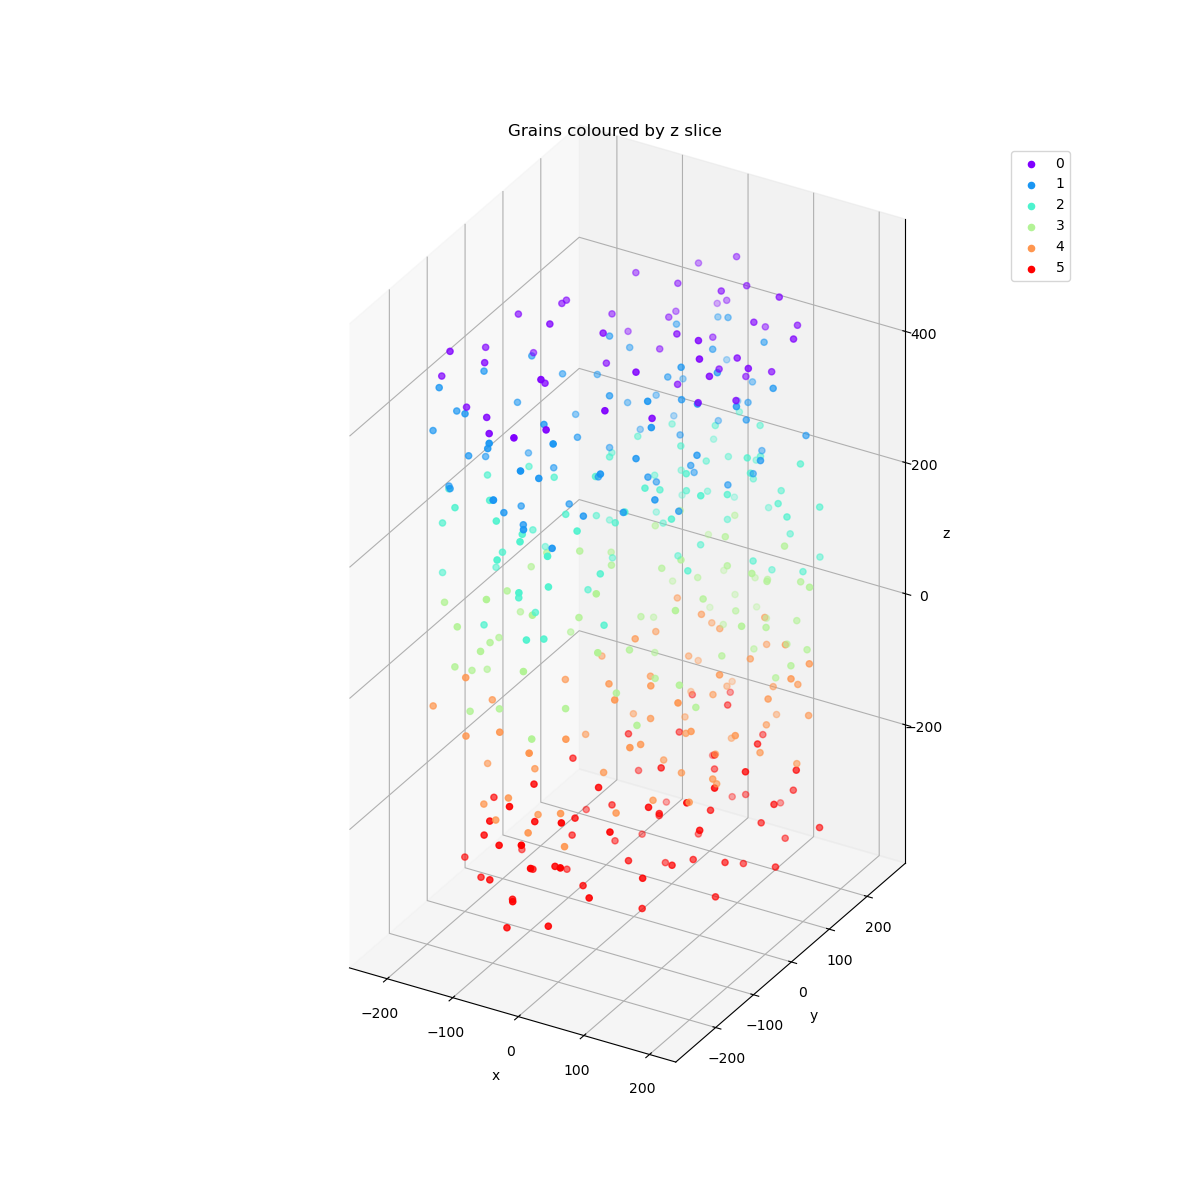

In [17]:
centre_plot = False
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d', proj_type='ortho')
colors = cm.rainbow(np.linspace(0, 1, len(list(ds_dict.values()))))
for ds in ds_dict.values():
    xx = [grain.pos_sample[0] for grain in ds.grains]
    yy = [grain.pos_sample[1] for grain in ds.grains]
    zz = [grain.pos_sample[2] for grain in ds.grains]
    scatterplot = ax.scatter(xx, yy, zz, c=colors[ds.grains[0].z_slice], label=ds.grains[0].z_slice)
ax.set(title="Grains coloured by z slice", xlabel='x', ylabel='y', zlabel='z', aspect='equal')
ax.legend()
plt.show()

In [18]:
# grain deduplication philosophy
# create a Graph with networkx - each grain is a node on the graph
# build an adjacency matrix - every grain vs every other grain
# vectors on the graph are drawn based on whether two grains are considered to match
# then extract the connected components of the graph

In [19]:
len(all_grains)

423

In [20]:
crystal_system_number = 7  # cubic

def misorien_deg(U1, U2, crystal_system_number=7):
    return Umis(U1, U2, crystal_system_number)[:, 1].min()  # 7 == cubic

# euclidean distance function
def eudis(v1, v2):
    return np.linalg.norm(v1-v2)

def are_grains_duplicate(grain_a, grain_b, distance_tolerance=25, angle_tolerance=2):
    # are they the same grain?
    if grain_a is grain_b:
        return False
    # # are they from the same slice?
    # if grain_a.z_slice == grain_b.z_slice:
    #     return False
    # now check their euclidean distance
    translation = eudis(grain_a.pos_sample, grain_b.pos_sample)
    if translation > distance_tolerance:
        return False
    misorien = misorien_deg(grain_a.U, grain_b.U)
    if misorien > angle_tolerance:
        return False
    # if we got here, we have a misorientation match
    return True

In [21]:
adjacency_matrix = np.zeros((len(all_grains), len(all_grains))).astype(bool)
inds = np.array(np.triu_indices(adjacency_matrix.shape[0])).T  # upper triangular indices to the adjacency matrix

distance_tolerance_for_merging_grains = 150
angular_tolerance_for_merging_grains = 0.5

for ind in tqdm(inds):
    i_a, i_b = ind
    grain_a = all_grains[i_a]
    grain_b = all_grains[i_b]
    if are_grains_duplicate(grain_a, grain_b, distance_tolerance_for_merging_grains, angular_tolerance_for_merging_grains):
        adjacency_matrix[*ind] = 1

print(np.sum(adjacency_matrix))

  0%|          | 0/89676 [00:00<?, ?it/s]

141


In [22]:
# build networkx graph

G = nx.from_numpy_array(adjacency_matrix)
components = list(nx.connected_components(G))

In [23]:
def merge_grains(grains_to_merge, distance_tolerance=25, angle_tolerance=2):
    grain_positions = np.array([g.pos_sample for g in grains_to_merge])
    
    # take first grain in grains_to_merge
    # take the fundamental zone of that grain
    # move all other grains into the same fundamental zone
    first_grain = grains_to_merge[0]
    umats_fz = []
    umats_fz.append(first_grain.U)
    for g in grains_to_merge[1:]:
        umis_out = Umis(g.U, first_grain.U, 7)
        rot_operator_idx = np.argmin(umis_out[:, 1])
        rot_operator = ROTATIONS[7][rot_operator_idx]
        second_grain_in_fz = g.U @ rot_operator.T
        umats_fz.append(second_grain_in_fz)
        
    grain_umats = np.array(umats_fz)
    # find_uniq_u has corner cases!
    grain_as = np.array([np.linalg.inv(g.B) for g in grains_to_merge])
    grain_volumes = np.array([g.mean_int for g in grains_to_merge])
    vol_weighted_umat = R.from_matrix(grain_umats).mean(weights=grain_volumes).as_matrix()
    vol_weighted_position = np.average(grain_positions, weights=grain_volumes, axis=0)
    vol_weighted_amat = np.average(grain_as, weights=grain_volumes, axis=0)
    vol_weighted_bmat = np.linalg.inv(vol_weighted_amat)
    vol_weighted_ubi = np.linalg.inv(vol_weighted_umat.dot(vol_weighted_bmat))
    new_grain = ImageD11.grain.grain(vol_weighted_ubi)
    new_grain.pos_sample = vol_weighted_position
    new_grain.names = [g.name for g in grains_to_merge]
    new_grain.mean_int = np.sum(grain_volumes)
    
    # new grain should be close to first grain
    assert eudis(new_grain.pos_sample, grains_to_merge[0].pos_sample) < distance_tolerance, eudis(new_grain.pos_sample, grains_to_merge[0].pos_sample)
    assert misorien_deg(new_grain.U, grains_to_merge[0].U) < angle_tolerance, misorien_deg(new_grain.U, grains_to_merge[0].U)
    
    return new_grain

In [24]:
# build list of merged grains
merged_grains = []
# comp is a list of dictionaries
for comp in tqdm(list(nx.connected_components(G))):
    # list of grain IDs
    cl = list(comp)
    # list of grains
    grains_here = [all_grains[inc] for inc in cl]
    if len(grains_here) == 1:
        merged_grains.append(grains_here[0])
    else:
        gnew = merge_grains(grains_here, distance_tolerance_for_merging_grains, angular_tolerance_for_merging_grains)
        merged_grains.append(gnew)

  0%|          | 0/284 [00:00<?, ?it/s]

In [25]:
for g in merged_grains:
    g.ref_unitcell = ucell

utils.get_rgbs_for_grains(merged_grains)

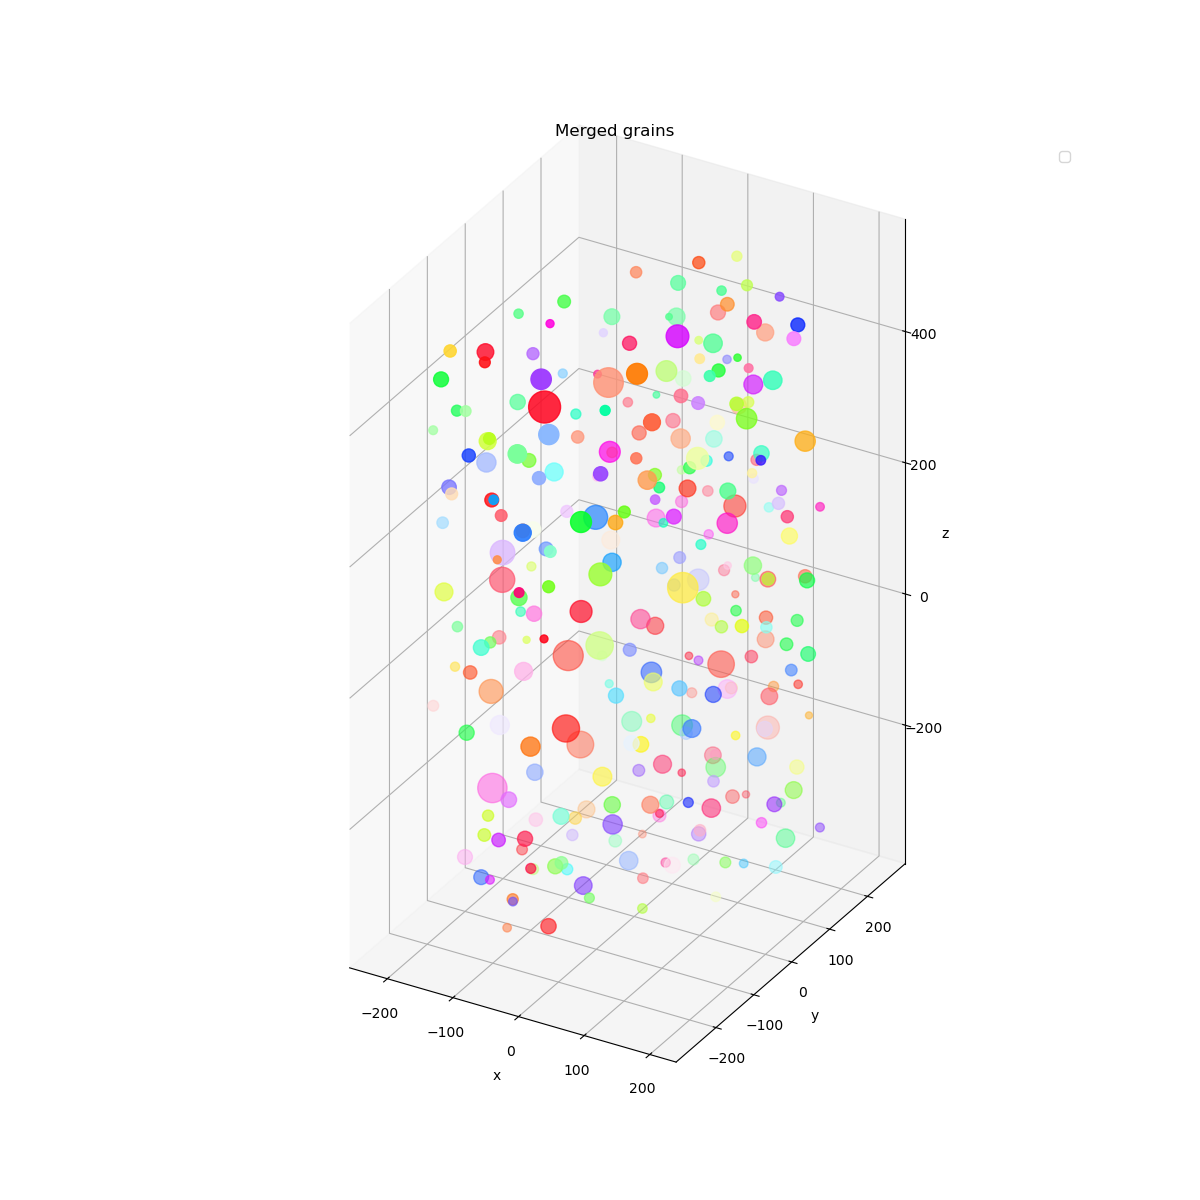

In [26]:
centre_plot = False
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d', proj_type='ortho')
xx = [grain.pos_sample[0] for grain in merged_grains]
yy = [grain.pos_sample[1] for grain in merged_grains]
zz = [grain.pos_sample[2] for grain in merged_grains]
c = [grain.rgb_z for grain in merged_grains]
scatterplot = ax.scatter(xx, yy, zz, c=c, s=[0.1*np.power(g.mean_int, 2/3) for g in merged_grains])
ax.set(title="Merged grains", xlabel='x', ylabel='y', zlabel='z', aspect='equal')
ax.legend()
plt.show()